In [650]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sb
from scipy.stats import kurtosis, skew, spearmanr
from scipy.linalg import norm, lstsq
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
from scipy.stats import mode

In [2]:
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = lstsq(C[:, idx], C[:, j])[0]
            beta_j = lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

/tmp/ipykernel_56024/2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/tmp/ipykernel_56024/2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/tmp/ipykernel_56024/2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/tmp/ipykernel_56024/2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i]

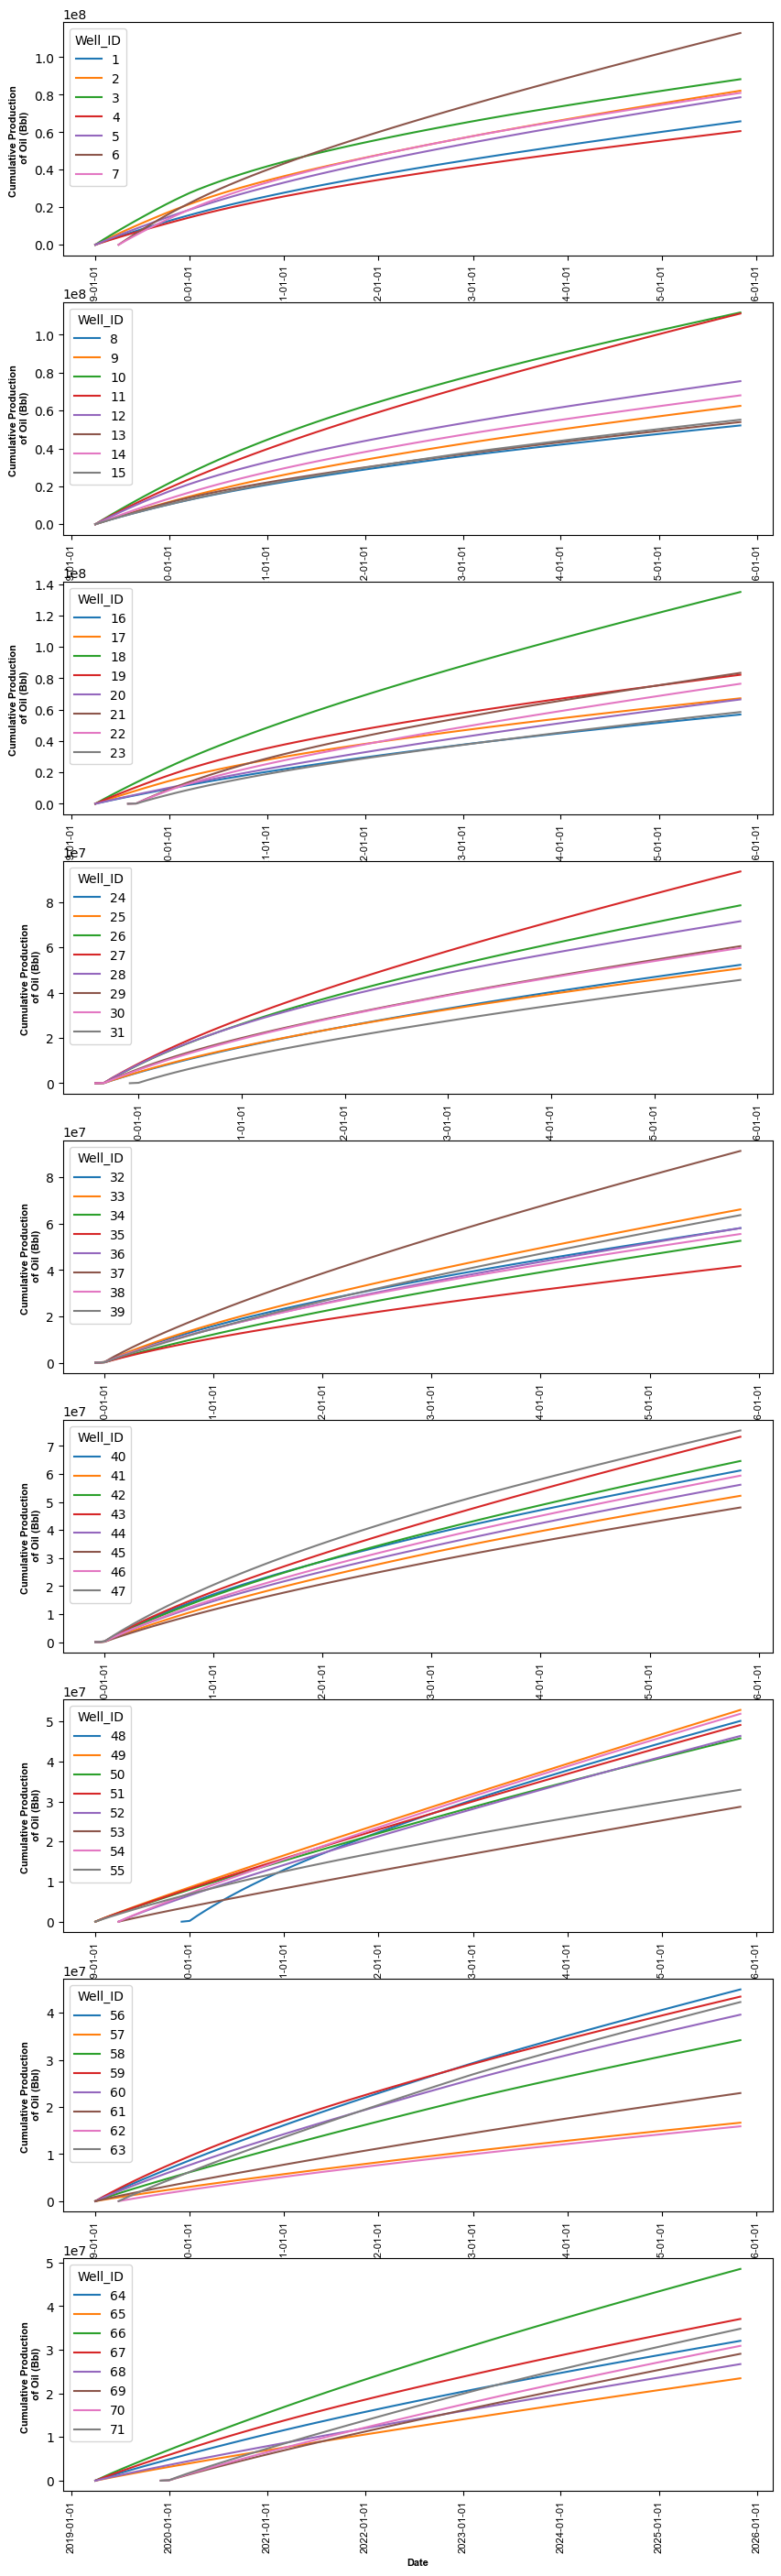

In [423]:


df = pd.read_csv( "production.csv",parse_dates=["Date"] )
fig,ax = plt.subplots( 9,1,figsize=(10,35) )




for i in range(9):
    wellidx     = i*8
    sb.lineplot( data=df[(df["Well_ID"]>=wellidx) & (df["Well_ID"]<=wellidx+7)], x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax[i] )
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [39]:
np.unique( df["Well_ID"] )

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71])

/tmp/ipykernel_56024/2628011662.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


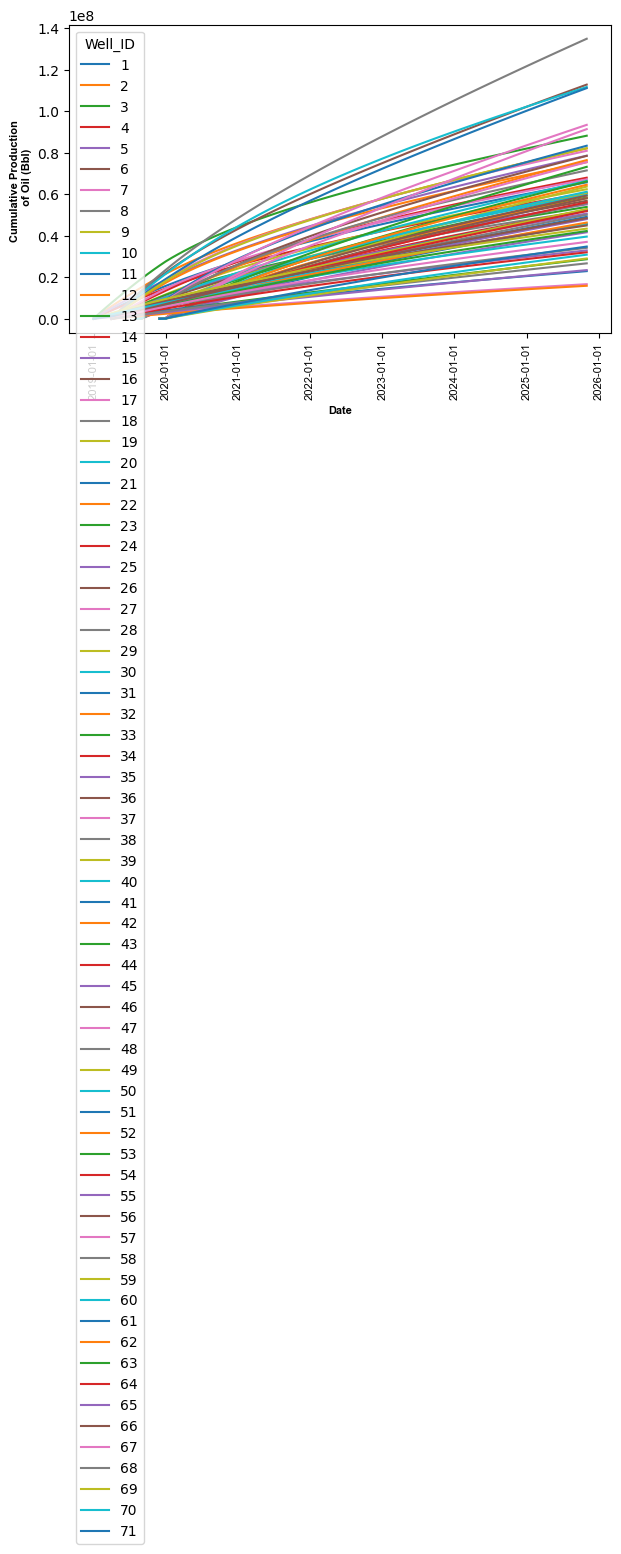

In [5]:
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=df, x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [446]:
dflogs = pd.read_csv( "logs.csv" )
 
df["gamma_var"] = 0
df["gamma_skew"] = 0
df["months"] = 0
df["mean_por"] = 0
df["mean_perm"] = 0
df["kurt_perm"] = 0
df["neighbor_density_25"] = 0
df["neighbor_density_70"] = 0
df["X"] = 0
df["Y"] = 0
df["cumulative_3y"] = 0
df["gamma_mean"] = 0
df["facies_p75"] = 0
df["z_mean"] = 0
df["acoustic_imp"] = 0
df["kophi_sqrt_of_means"] = 0
df["kophi_mean_of_sqrts"] = 0

def calculate_well_density( xvals,yvals,allx,ally,allIDs,quantile ):
    x   = xvals[0]
    y   = yvals[0]
    ids = np.unique( allIDs )
    dists = [  ]
    for id in ids:
        idxs=np.argwhere( allIDs==id )
        xs  = allx[idxs][0]
        ys  = ally[idxs][0]
        if x!=xs and y!=ys:
            dists.append( 1/norm( np.array([x-xs,y-ys]) ) )
    return np.min( dists )

for id in np.unique(dflogs["Well_ID"]):
    df.loc[df["Well_ID"]==id,"X"] = np.unique( dflogs[dflogs["Well_ID"]==id]["X"] )[0]
    df.loc[df["Well_ID"]==id,"Y"] = np.unique( dflogs[dflogs["Well_ID"]==id]["Y"] )[0]
    df.loc[df["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
    df.loc[df["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI"] )
    df.loc[df["Well_ID"]==id,"kophi_mean_of_sqrts"] = ( np.mean( np.sqrt(dflogs[dflogs["Well_ID"]==id]["perm"]/dflogs[dflogs["Well_ID"]==id]["phi"] ) ) )
    df.loc[df["Well_ID"]==id,"z_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["Z"] )
    df.loc[df["Well_ID"]==id,"gamma_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["GR"] )
    df.loc[df["Well_ID"]==id,"facies_p75"] = np.quantile( dflogs[dflogs["Well_ID"]==id]["facies"],0.75 )
    df.loc[df["Well_ID"]==id,"gamma_skew"] = skew( dflogs[dflogs["Well_ID"]==id]["GR"].values )
    df.loc[df["Well_ID"]==id,"mean_por"] = np.mean( dflogs[dflogs["Well_ID"]==id]["phi"] )
    df.loc[df["Well_ID"]==id,"mean_perm"] = np.mean( dflogs[dflogs["Well_ID"]==id]["perm"] )
    df.loc[df["Well_ID"]==id,"kurt_perm"] = kurtosis( dflogs[dflogs["Well_ID"]==id]["perm"].values )
    df.loc[df["Well_ID"]==id,"neighbor_density_25"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.25 )
    df.loc[df["Well_ID"]==id,"neighbor_density_70"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.7 )
    df.loc[df["Well_ID"] == id, "months"] = (
        df.loc[df["Well_ID"] == id, "Date"]
        - df.loc[df["Well_ID"] == id, "Date"].min(  )
    ).dt.days
    monthsWell          = df[df["Well_ID"]==id]["months"] - 36
    prodWell          = df[df["Well_ID"]==id]["Cumulative Oil Production, BBL"]
    df.loc[df["Well_ID"]==id,"cumulative_3y"] = np.min( prodWell[monthsWell>0] )
    
df["months"]=df["months"]/30

/tmp/ipykernel_56024/571528975.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.616559342992652' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
/tmp/ipykernel_56024/571528975.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5096851.315789473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI"] )
/tmp/ipykernel_56024/571528975.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.70295417296884' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


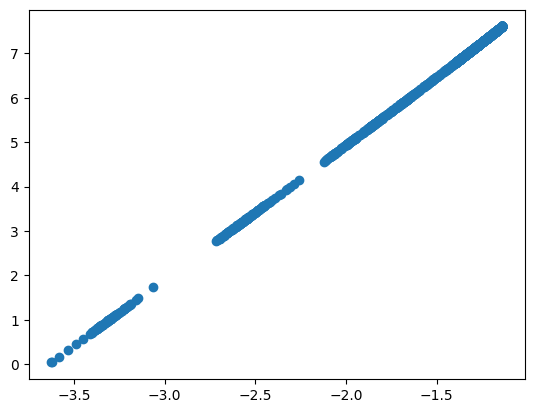

In [184]:
plt.scatter( np.log( dflogs["phi"] ),np.log(dflogs["perm"]) )

In [445]:
df

,Well_ID,Date,"Cumulative Gas Production, ft3","Cumulative Oil Production, BBL","Cumulative Water Production, BBL",gamma_var,gamma_skew,months,mean_por,mean_perm,...,neighbor_density_70,X,Y,cumulative_3y,gamma_mean,facies_p75,z_mean,acoustic_imp,kophi_sqrt_of_means,kophi_mean_of_sqrts
0,1,2019-01-01,0.000000e+00,0.00,0.000000e+00,12.616559,NaN,0.000000,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
1,1,2019-02-01,1.981249e+09,1560038.50,4.634771e+04,12.616559,NaN,1.033333,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
2,1,2019-03-01,3.661006e+09,2882681.25,8.738335e+04,12.616559,NaN,1.966667,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
3,1,2019-04-01,5.474707e+09,4310793.00,1.334990e+05,12.616559,NaN,3.000000,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
4,1,2019-05-01,7.194637e+09,5665069.00,1.791346e+05,12.616559,NaN,4.000000,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,71,2025-07-01,4.209285e+10,33143974.00,2.761039e+06,27.173784,0.225046,67.966667,0.176152,429.657251,...,0.005708,151,166,812823.00,58.07322,5.0,29,6.083808e+06,0,42.329698
5513,71,2025-08-01,4.262622e+10,33563956.00,2.809077e+06,27.173784,0.225046,69.000000,0.176152,429.657251,...,0.005708,151,166,812823.00,58.07322,5.0,29,6.083808e+06,0,42.329698
5514,71,2025-09-01,4.315820e+10,33982832.00,2.857320e+06,27.173784,0.225046,70.033333,0.176152,429.657251,...,0.005708,151,166,812823.00,58.07322,5.0,29,6.083808e+06,0,42.329698
5515,71,2025-10-01,4.367173e+10,34387188.00,2.904204e+06,27.173784,0.225046,71.033333,0.176152,429.657251,...,0.005708,151,166,812823.00,58.07322,5.0,29,6.083808e+06,0,42.329698


In [95]:
dflogs

,Well_ID,X,Y,Z,AI,SI,Vp,Vs,rho_b,rho_f,...,Kdry,Kf,Ksat,G0,Gdry,Gsat,facies,phi,perm,GR
0,1,33,127,19,5943276.00,NaN,2509.036133,1090.884644,2.368749,1.031188,...,3.545598,2.053309,11.153387,22.357136,2.818880,2.818880,4.0,0.168519,270.908982,64.492799
1,1,33,127,20,5919975.00,2565816.00,2501.055908,NaN,2.366990,1.031302,...,3.522153,2.054320,11.097732,22.127697,2.781343,NaN,4.0,0.169546,275.991820,59.381030
2,1,33,127,21,5964042.00,2626229.75,2520.884766,1110.056396,2.365853,1.031283,...,NaN,2.054156,11.147645,23.269091,2.915263,2.915263,4.0,0.170632,281.433205,58.695883
3,1,33,127,22,7214826.00,3753484.00,2968.669678,1544.438354,2.430323,1.015337,...,5.419065,1.922070,13.689069,33.429173,5.797025,5.797025,3.0,0.131763,128.040537,39.931218
4,1,33,127,23,7219024.00,3770280.75,2972.544189,NaN,2.428567,1.015382,...,5.423145,1.922422,13.654531,33.858128,5.853251,5.853251,3.0,0.132931,NaN,37.518093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,71,151,166,35,4095578.25,1889011.00,1893.622070,873.398743,2.162828,0.922046,...,1.309159,1.396673,5.555665,42.209805,1.649860,1.649860,2.0,0.281013,1325.150121,33.343715
1487,71,151,166,36,4142597.25,1914249.00,1907.745605,881.548462,2.171462,0.922793,...,NaN,1.399736,5.653017,42.189388,1.687503,1.687503,2.0,0.276123,1253.468462,20.888743
1488,71,151,166,37,4189854.00,1941441.25,1921.716187,890.460388,2.180267,0.922656,...,1.368478,1.399171,NaN,42.197090,1.728777,1.728777,2.0,0.270999,1181.391043,25.646714
1489,71,151,166,38,4234563.50,1969158.75,1934.696655,899.673523,2.188748,0.921575,...,1.398950,1.394749,5.830463,NaN,1.771600,1.771600,2.0,0.265927,1113.016864,22.504533


/tmp/ipykernel_56024/1949035277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


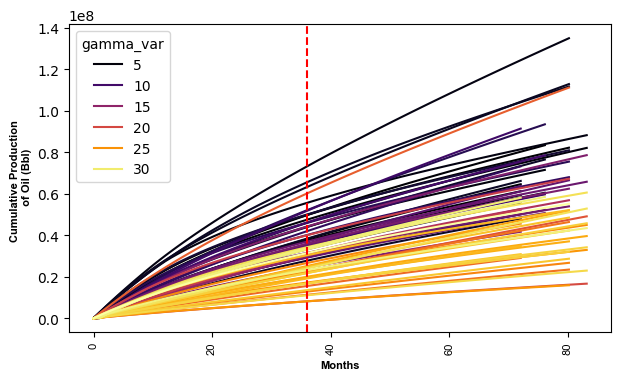

In [7]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_var",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_41617/681984011.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


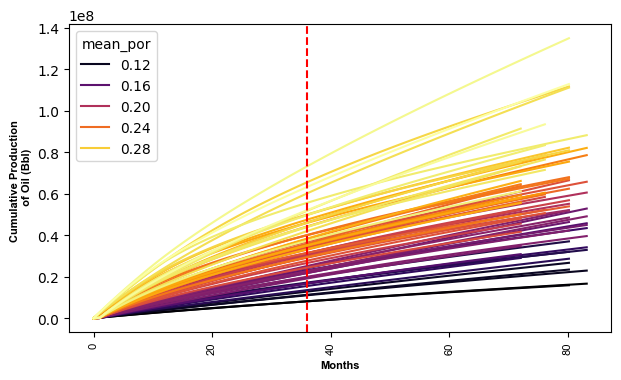

In [97]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_por",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_41617/2076334418.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


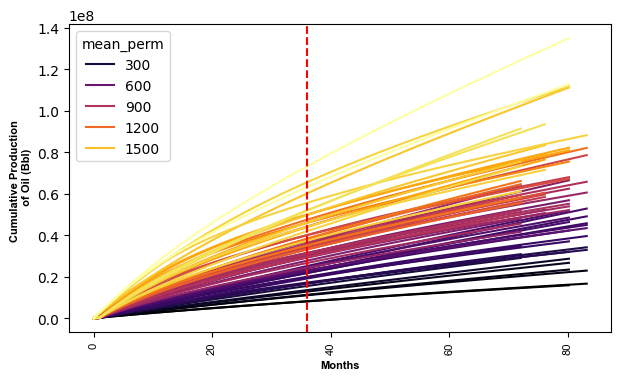

In [98]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_perm",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_41617/1183271054.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


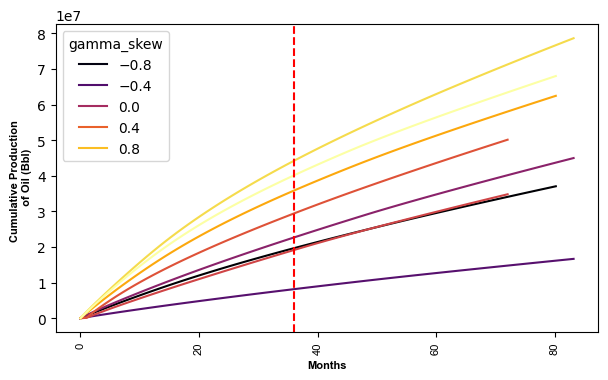

In [163]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_skew",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_41617/1660267431.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


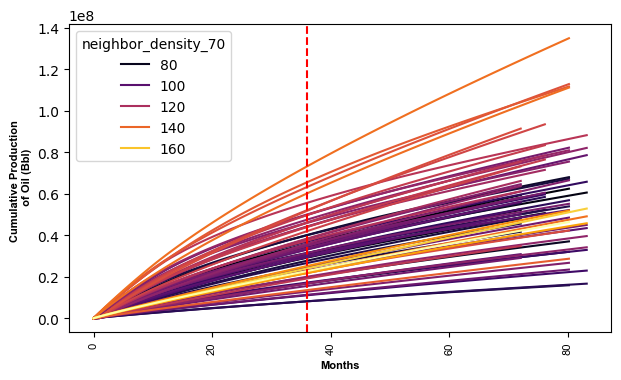

In [110]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="neighbor_density_70",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

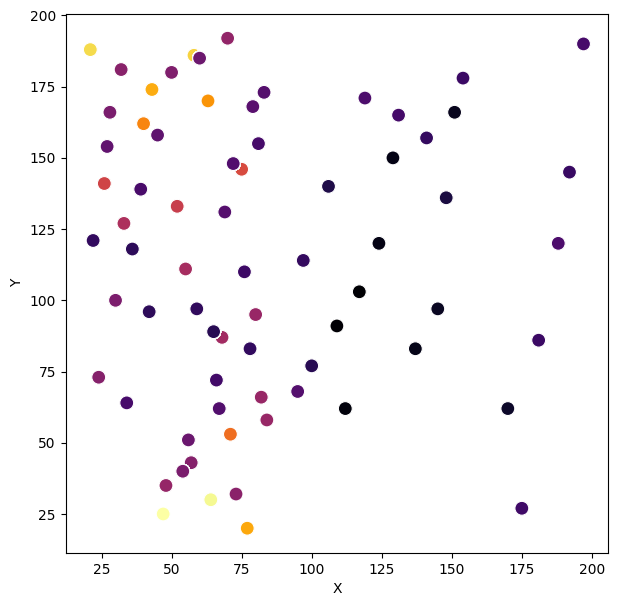

In [185]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="cumulative_3y",palette="inferno",ax=ax,s=100 );
ax.legend().remove()


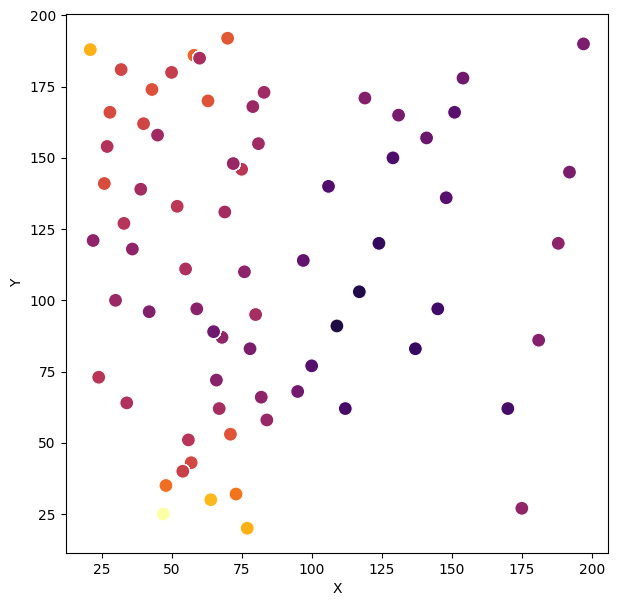

In [186]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

In [ ]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

In [447]:
df_out = df.groupby("Well_ID", as_index=False).first(  )

In [448]:
df_out = df_out[["gamma_var","gamma_mean","mean_por","mean_perm","neighbor_density_25","neighbor_density_70","facies_p75","Y","X","acoustic_imp","kophi_mean_of_sqrts","Well_ID","cumulative_3y"]]

/tmp/ipykernel_56024/258000566.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(  ),rotation=90);
/tmp/ipykernel_56024/258000566.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(  ),rotation=90);
/tmp/ipykernel_56024/258000566.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticklabels(  ),rotation=90);


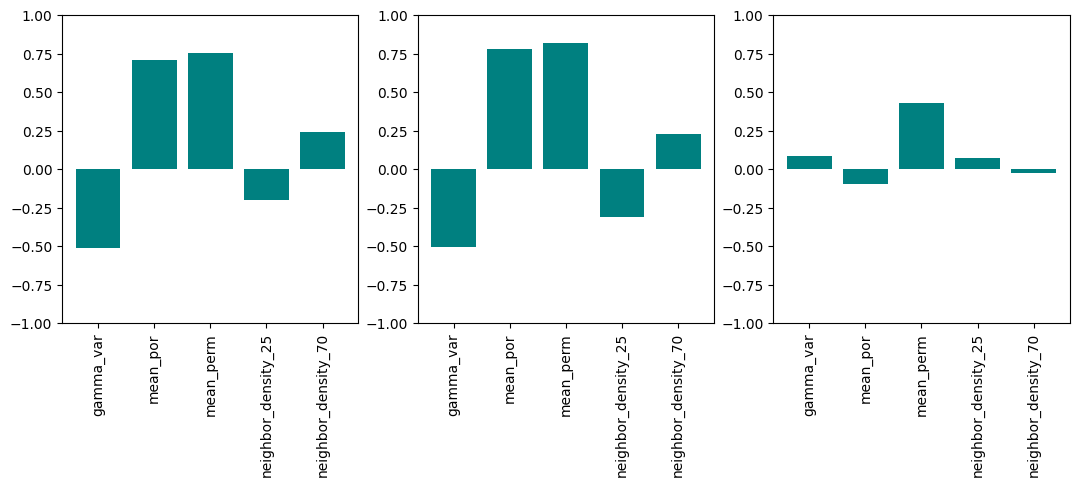

In [13]:
corrs  = [  ]
rcorrs = [  ]
pcorrs =  partial_corr(df_out.values)[:,-1][:-1]

features = [ "gamma_var","mean_por","mean_perm","neighbor_density_25","neighbor_density_70" ]
for f in features:
    corrs.append( pearsonr( df_out[f],df_out["cumulative_3y"] )[0] )
    rcorrs.append( spearmanr( df_out[f],df_out["cumulative_3y"] )[0] )
    
fig,ax = plt.subplots(1,3,figsize=(13,4))
ax[0].bar( features,corrs,color="teal" );
ax[0].set_ylim(-1,1)
ax[0].set_xticklabels(ax[0].get_xticklabels(  ),rotation=90);

ax[1].bar( features,rcorrs,color="teal" );
ax[1].set_ylim(-1,1)
ax[1].set_xticklabels(ax[1].get_xticklabels(  ),rotation=90);

ax[2].bar( features,pcorrs,color="teal" );
ax[2].set_ylim(-1,1)
ax[2].set_xticklabels(ax[2].get_xticklabels(  ),rotation=90);

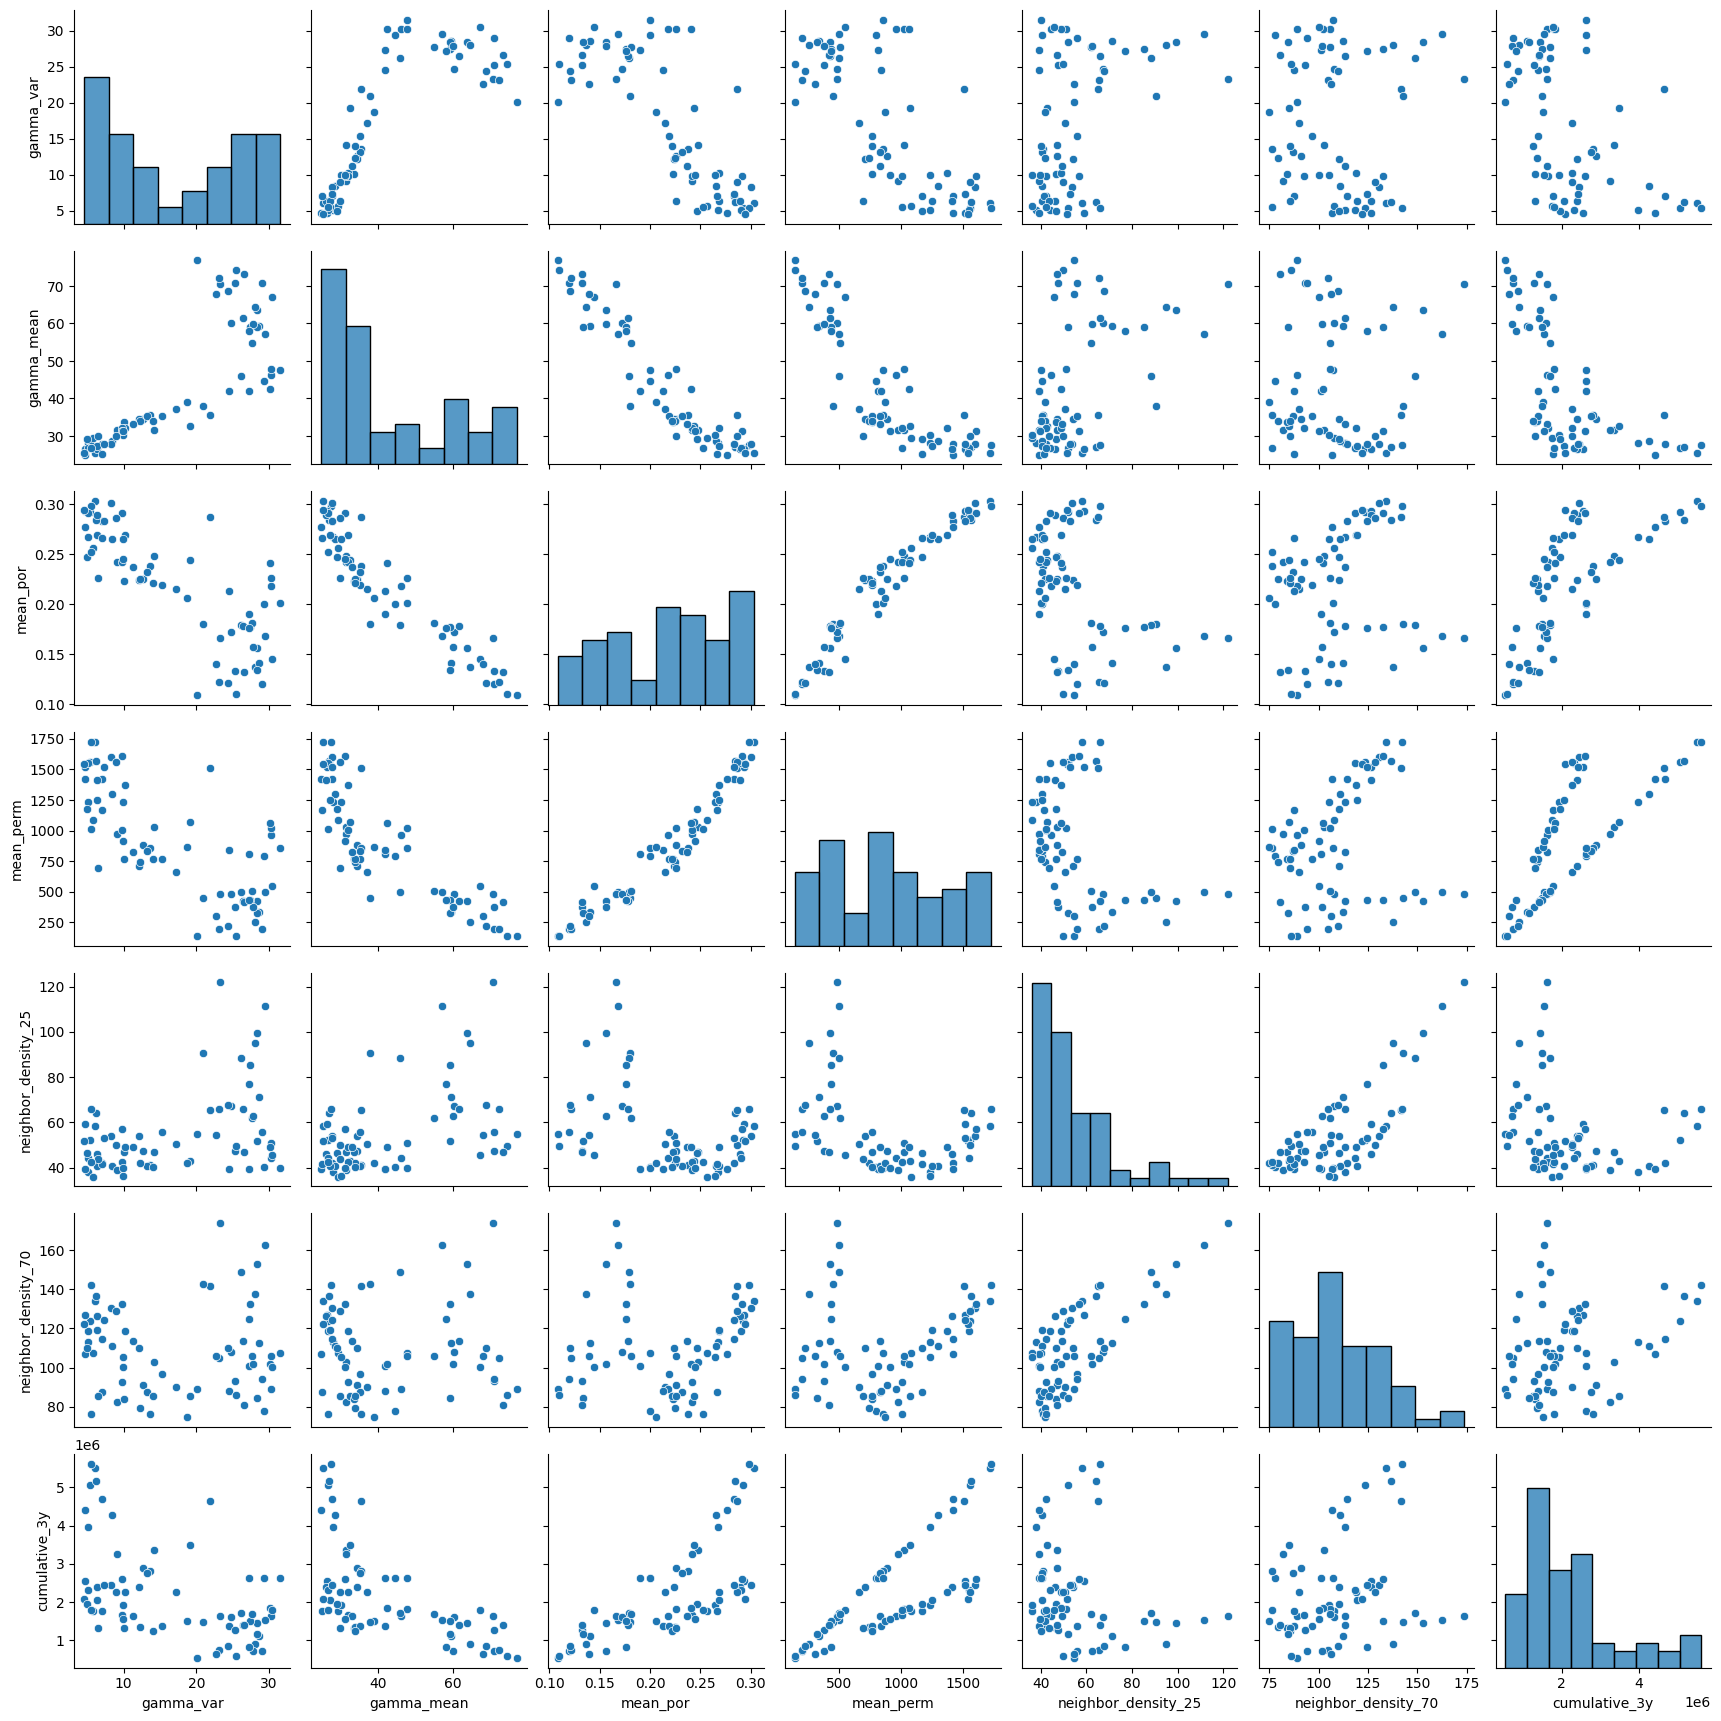

In [123]:
sb.pairplot(df_out)

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

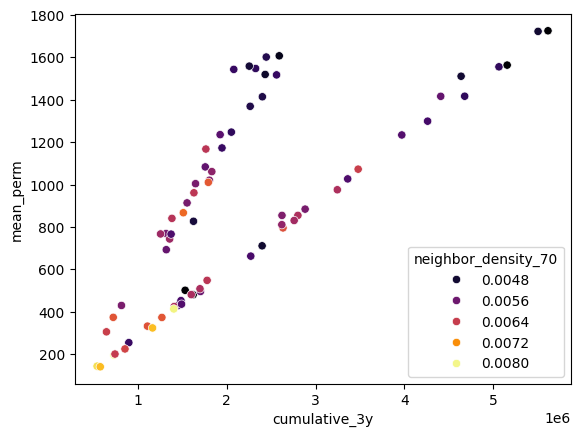

In [455]:
df_out["is_crowded"] = np.where(df_out["neighbor_density_70"]>0.006,1,0)
# sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="is_crowded",palette="inferno" )
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="neighbor_density_70",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

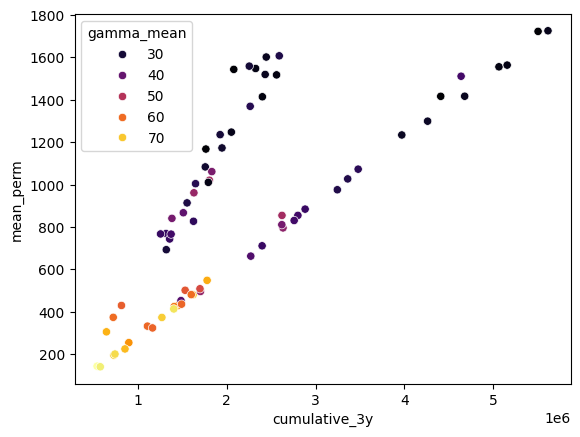

In [131]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="gamma_mean",palette="inferno" )

In [427]:
df_facies = pd.read_csv("facies.csv")
df_out["facies_percentage"] = df_facies["Percentage_Facies_3_or_Less"]

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

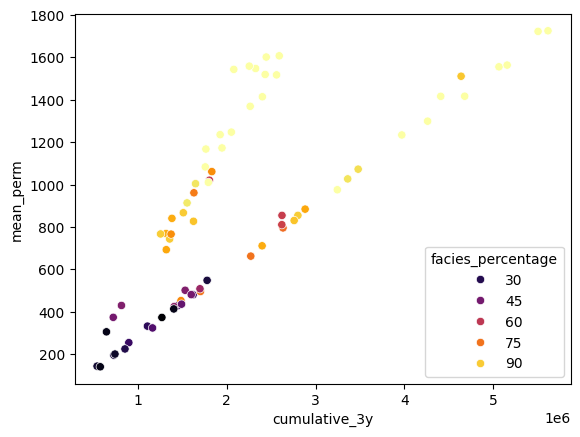

In [290]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="facies_percentage",palette="inferno" )

In [428]:
df_out["y_north"] = np.where( (df_out["X"]<100) & (df_out["Y"]<100),"North","South" )
df_out["x_east"] = np.where( df_out["X"]>=80,"East","West" )
df_out["region"] = np.where( (df_out["X"]<=90) & ((df_out["Y"]<70) | (df_out["Y"]>125)),"in_region","out_region" )
df_out["region_north"] = np.where( (df_out["region"]=="in_region") & (df_out["Y"]<100),"in_region_north","in_region_south" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

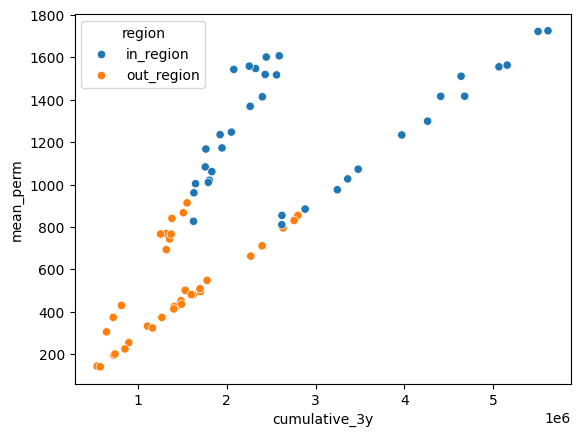

In [265]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="region",palette="tab10" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

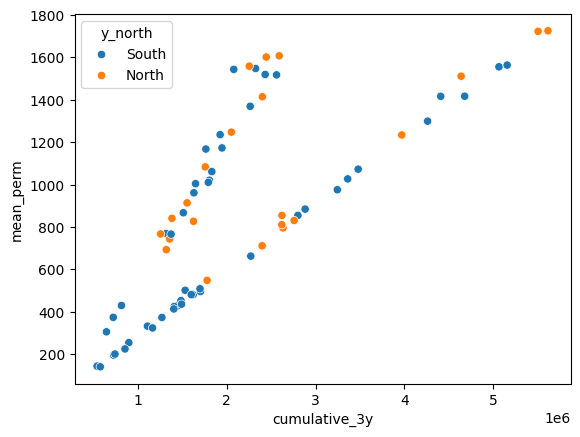

In [202]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="y_north",palette="tab10" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

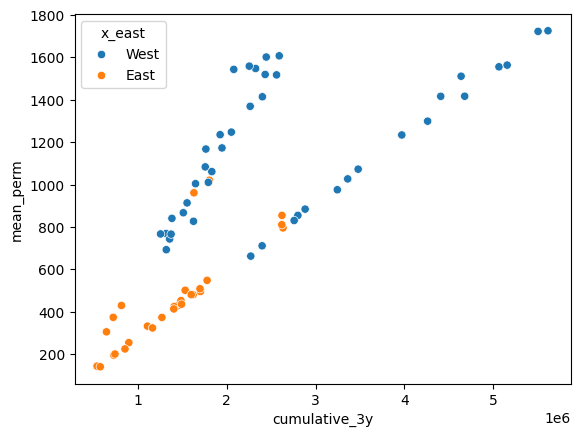

In [153]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="x_east",palette="tab10" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

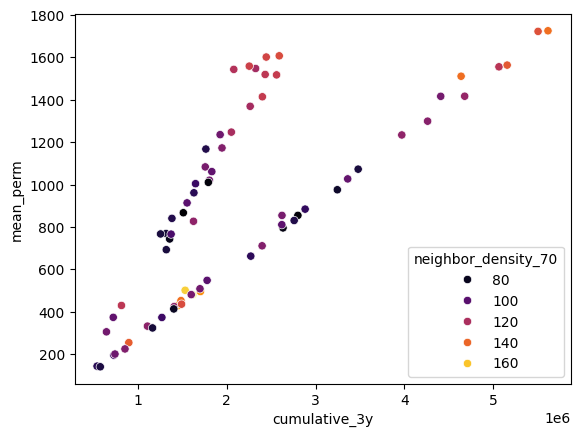

In [184]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="neighbor_density_70",palette="inferno" )

In [429]:
df_mechanical = pd.read_csv( "mechanical.csv" )
df_out["brittleness"] = df_mechanical["Mean_Brittleness_Index"]
df_out["young"] = df_mechanical["Mean_Youngs_Modulus_Velocities"]
df_out["poisson"] = df_mechanical["Mean_Poisson_Ratio_Ksat_Gsat"]

In [430]:
df_out["is_well_id"] = np.where(df_out["Well_ID"]>50,"fifties","forties")

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

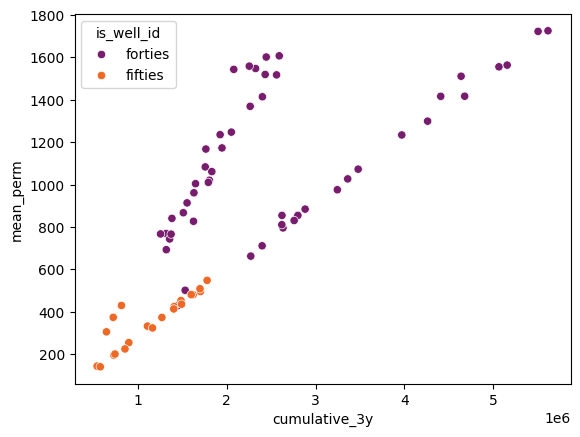

In [239]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="is_well_id",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

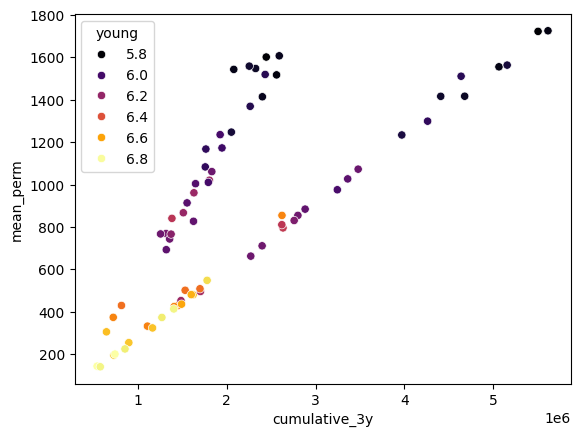

In [190]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="young",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

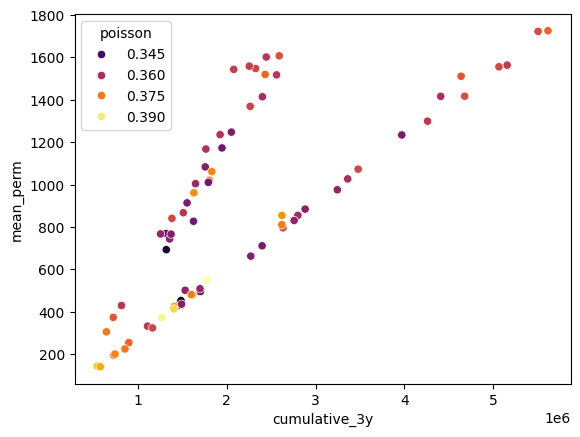

In [192]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="poisson",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

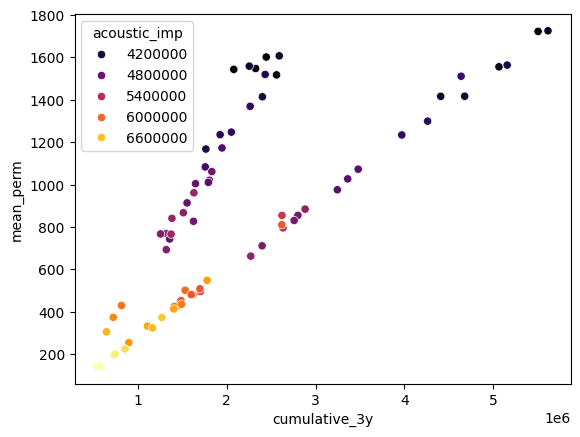

In [208]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="acoustic_imp",palette="inferno" )


<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

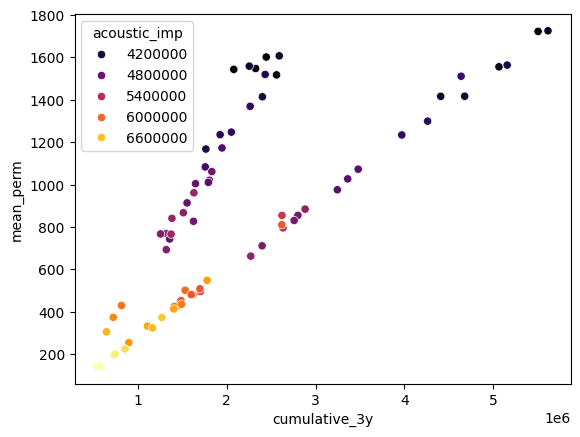

In [269]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="acoustic_imp",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

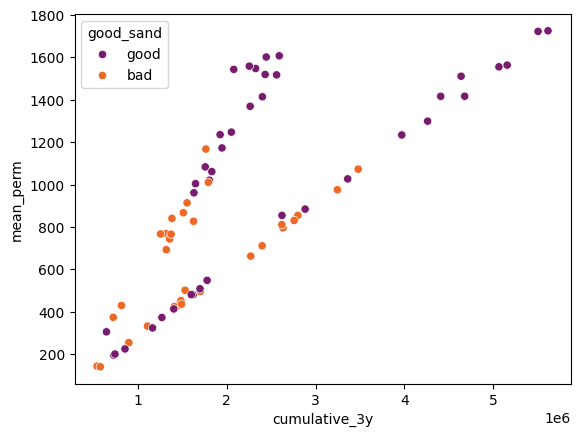

In [277]:
df_perm_facies = pd.read_csv("perm_facies.csv")
df_out["mean_perm_f2"] = df_perm_facies["facies_2"]
df_out["good_sand"] = np.where( df_perm_facies["facies_2"]>1200,"good","bad" )
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="good_sand",palette="inferno" )

<Axes: xlabel='mean_perm', ylabel='cumulative_3y'>

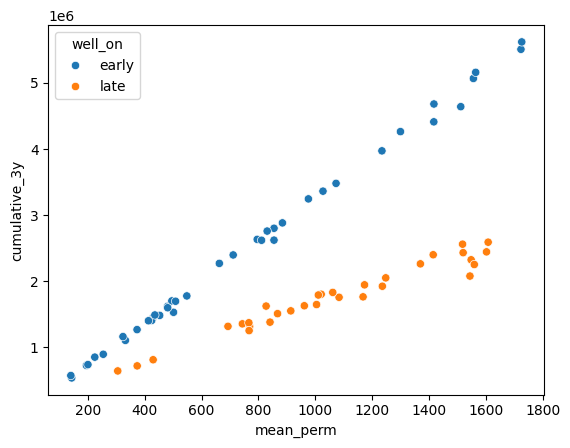

In [431]:
df_times = pd.read_csv( "times.csv",parse_dates=["earliest"] )
df_times["is_before_cutoff_2"] = np.where( df_times["earliest"]<pd.to_datetime( "2019-08-01",format="%Y-%m-%d" ),1,0 )
df_out["well_on"] = np.where(df_times["is_before_cutoff_2"],"early","late")
sb.scatterplot( data=df_out,y="cumulative_3y",x="mean_perm",hue="well_on",palette="tab10" )

## Training Model with Only Late Wells

/tmp/ipykernel_56024/2484556113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
/tmp/ipykernel_56024/2484556113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["logperm"] = np.log( df_train["mean_perm"] )


<Axes: xlabel='logperm', ylabel='cumulative_3y'>

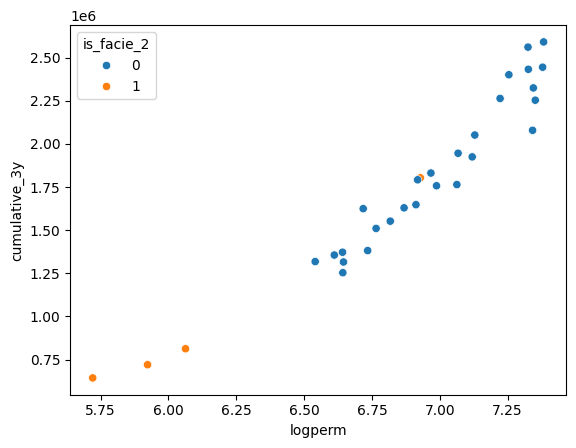

In [432]:
df_train = df_out[df_out["well_on"]=="late"]
df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
df_train["logperm"] = np.log( df_train["mean_perm"] )
sb.scatterplot( data=df_train,x="logperm",y="cumulative_3y",hue="is_facie_2",palette="tab10" )

/home/acmontesh/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.055e+11, tolerance: 5.924e+08
  model = cd_fast.enet_coordinate_descent(
/home/acmontesh/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e+11, tolerance: 7.611e+08
  model = cd_fast.enet_coordinate_descent(
/home/acmontesh/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

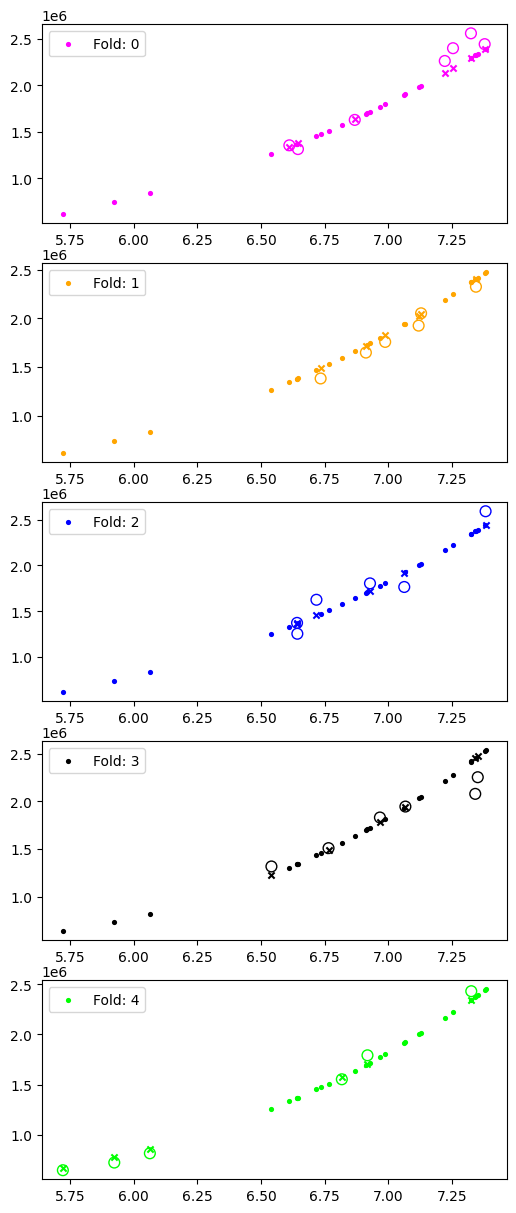

In [ ]:
fig,ax = plt.subplots( 5,1,figsize=(6,15) )

X = df_train["logperm"].values
# X = df_train[["X","Y"]].values
y = df_train["cumulative_3y"].values
kf = KFold(n_splits=5 ,shuffle=False)
r2scores = [  ]
cols = ["magenta","orange","blue","black","lime"]

for i, (train_index, test_index) in enumerate(kf.split(X)):

    poly=PolynomialFeatures(degree=7,include_bias=True)    

    pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', Lasso(  ))] )
    X_train, X_test, y_train, y_test = X[train_index].reshape(-1,1),X[test_index].reshape(-1,1),y[train_index],y[test_index]
    poly_features=poly.fit_transform(X_train.reshape(-1,1))
    poly_test=poly.transform( X_test.reshape(-1,1) )
    pipe.fit(poly_features, y_train)

    ypred = pipe.predict( poly_test )
    ytrainpreds = pipe.predict( poly_features )  

    # ypred =   pipe.predict( X_test )
    # ytrainpreds = pipe.predict( X_train )

    ax[i].scatter( X_train,ytrainpreds,color=cols[i],lw=1.5,label=f"Fold: {i}",s=5 )
    ax[i].scatter( X_test,ypred,marker="x",s=20,color=cols[i] )
    ax[i].scatter( X_test,y_test,marker="o",s=60,edgecolors=cols[i],facecolors='None' )

    r2scores.append( r2_score( y[test_index],ypred ) )
    ax[i].legend(  )

# pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', BaggingRegressor( estimator=Lasso(  ),oob_score=True,n_estimators=100,bootstrap=True ))] )
# pipe.fit( X.reshape(-1,1),y )
# bag = pipe.named_steps["model"]
# oob_pred = bag.oob_prediction_


In [463]:
r2scores

[]

In [556]:
r2scores

[0.9207936568746695,
 0.9294461203677435,
 0.9168210177388874,
 0.68032510209622,
 0.9922152905707058]

## Uncertainty Model

In [734]:
realizations_per_sample = {  }
for i in range(df_train.shape[0]):
    withold_point = df_train.iloc[i,:]
    x_wh = withold_point["logperm"].reshape(-1,1)
    y_hw = withold_point["cumulative_3y"]
    new_df      = pd.concat( [df_train.iloc[0:i,:],df_train.iloc[i+1:,:]] )
    X           = new_df["logperm"].values
    y           = new_df["cumulative_3y"].values
    realizations_per_sample[ i ] = { "actual":y_hw,"reals":[  ] }
    for j in range(100):
        degree_rand = np.random.randint( 3 )   
        model_type_rand =  0#np.random.randint( 0,4 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ),AdaBoostRegressor(  ),LinearRegression(  )]
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.80 )
        model = model_types[model_type_rand]
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        if model_type_rand<=1:
            poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features=poly.fit_transform(X_train.reshape(-1,1))
            poly_test=poly.transform( x_wh.reshape(-1,1) )
            pipe.fit(poly_features, y_train)
            # ypred = pipe.predict( poly_test )
            # ytrainpreds = pipe.predict( poly_features )
            ywhp = pipe.predict( poly_test )[0]
        else:
            pipe.fit(X_train.reshape(-1,1), y_train)
            ywhp = pipe.predict( x_wh )[0]
        
        
        realizations_per_sample[ i ]["reals"].append( ywhp )


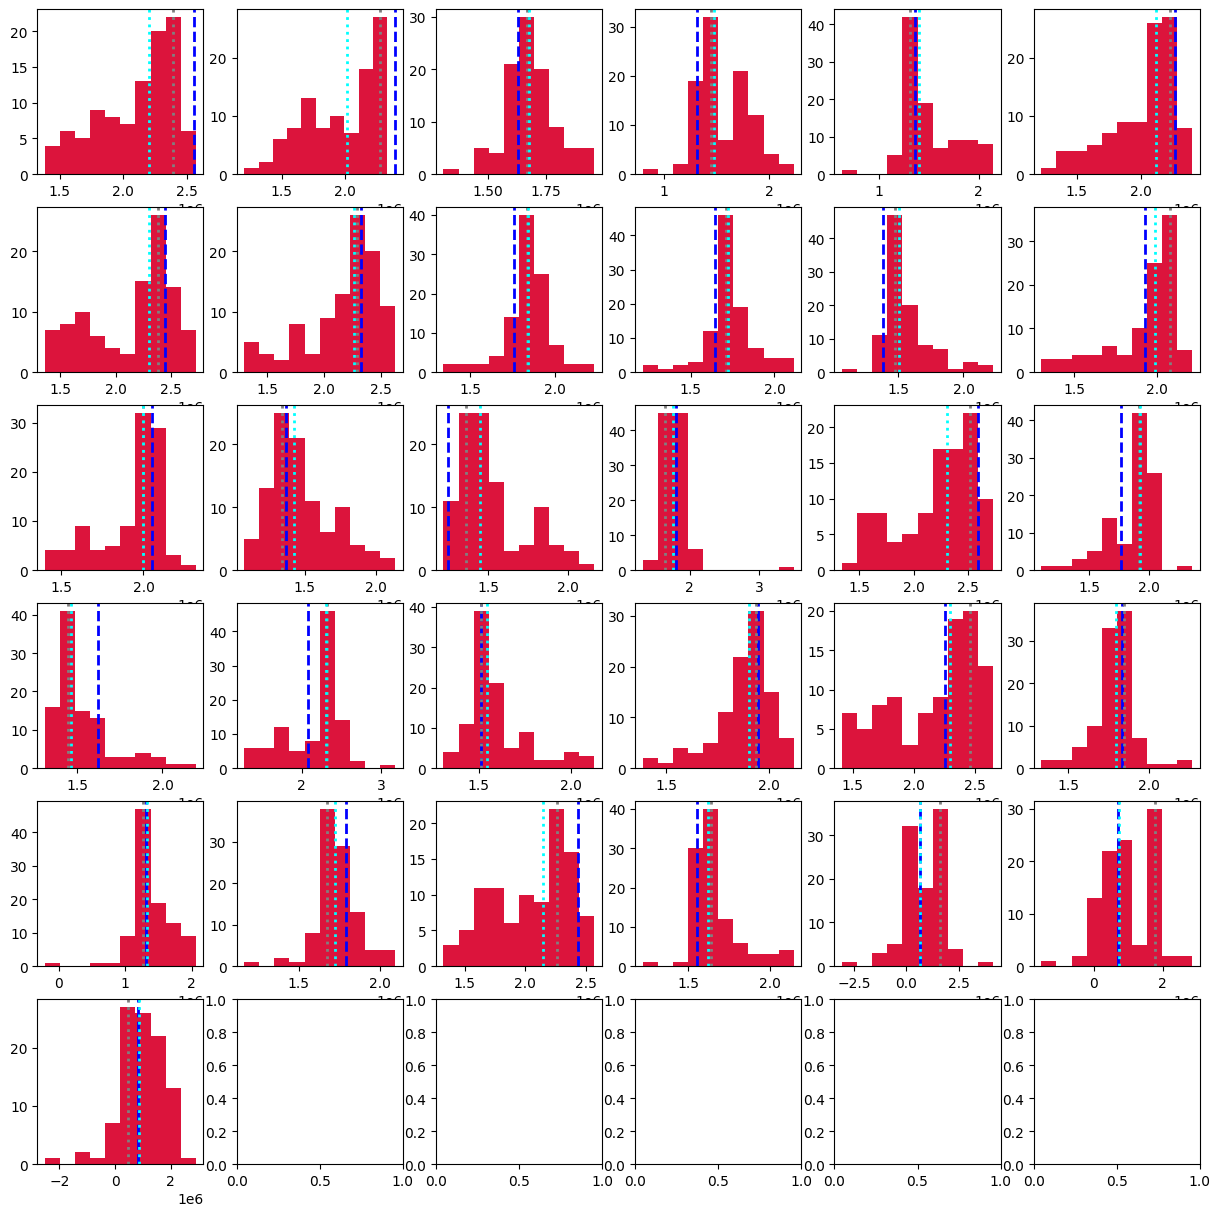

In [735]:
fig,axs = plt.subplots( 6,6,figsize=(15,15),facecolor="white" )
for k in range(df_train.shape[0]):
    row = k//6
    colm = k%6
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ k ]["reals"],color="crimson" )
    imax = np.argmax(counts)
    midpoint = 0.5 * (bin_edges[imax] + bin_edges[imax + 1])
    axs[row,colm].axvline( realizations_per_sample[ k ]["actual"],ls="--",lw=2.0,color="blue" )
    axs[row,colm].axvline( midpoint,ls="dotted",lw=2.0,color="gray" )
    axs[row,colm].axvline( np.median( realizations_per_sample[ k ]["reals"] ),ls="dotted",lw=2.0,color="cyan" )

In [736]:
counts = [ ]
for percent_value in np.arange(0,1.1,0.1):
    count = 0
    outside_range=1-percent_value
    for k in range(df_train.shape[0]):
        if (realizations_per_sample[ k ]["actual"]>=np.quantile( realizations_per_sample[ k ]["reals"],outside_range/2 )) and (realizations_per_sample[ k ]["actual"]<=np.quantile( realizations_per_sample[ k ]["reals"],1-outside_range/2 )):
            count += 1
    counts.append( count/df_train.shape[0] )
counts = np.array(counts)

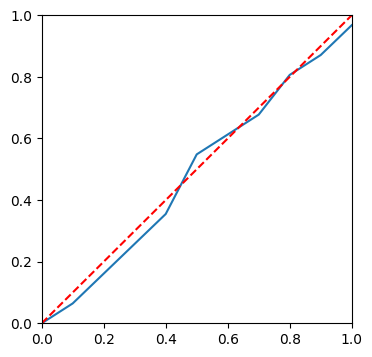

In [737]:
fig,ax = plt.subplots( figsize=(4,4) )
ax.plot( np.arange(0,1.1,0.1),counts )
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.add_line( Line2D( [0,1],[0,1],color="red",lw=1.5,ls="--" ) )


## FINAL PREDICTIONS

In [742]:
df_preproduction = pd.read_csv( "logs_preproduction.csv" )
df_preproduction["mean_perm"] = 0
for id in np.unique( df_preproduction["Well_ID"] ):
    print(np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] ))
    df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )

614.5193707165
1078.506667467619
936.0280205089524
1636.2010318947366
846.6214038333334
683.7977429293501
122.65067313336843
427.9245321080952
137.19931909204763
374.93761647785
286.17728327500004
433.69381494095234


/tmp/ipykernel_56024/2164575833.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '614.5193707165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )


In [743]:
df_preproduction = df_preproduction.groupby("Well_ID", as_index=False).first(  )

In [744]:
df_preproduction["logperm"] = np.log( df_preproduction["mean_perm"] )

In [745]:
realizations_per_sample = {  }
for i in range(df_preproduction.shape[0]):
    id = df_preproduction.iloc[i]["Well_ID"]
    Xinterest = df_preproduction.iloc[i]["logperm"]
    realizations_per_sample[ id ] = { "best_pred":0.0,"realizations":[  ] }
    for j in range(100):
        degree_rand = 3 #Tuned via resampling (see code above)
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.80 )
        model = LinearRegression(  ) #Selected via resampling (see code above)
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
        poly_features=poly.fit_transform(X_train.reshape(-1,1))
        poly_test=poly.transform( Xinterest.reshape(-1,1) )
        pipe.fit(poly_features, y_train)
        ypred = pipe.predict( poly_test )[0]            
        realizations_per_sample[ id ]["realizations"].append( ypred )
    realizations_per_sample[ id ]["best_pred"] = np.median( realizations_per_sample[ id ]["realizations"] )
    print( f"Best Prediction for Well {id} is: {realizations_per_sample[ id ]['best_pred']} BBL." )
    


Best Prediction for Well 72.0 is: 1159255.390819481 BBL.
Best Prediction for Well 73.0 is: 1816502.2946860362 BBL.
Best Prediction for Well 74.0 is: 1605748.0732488865 BBL.
Best Prediction for Well 75.0 is: 2459903.825406158 BBL.
Best Prediction for Well 76.0 is: 1481642.3234701394 BBL.
Best Prediction for Well 77.0 is: 1259051.3433825732 BBL.
Best Prediction for Well 78.0 is: 732841.3871905779 BBL.
Best Prediction for Well 79.0 is: 855315.2292597904 BBL.
Best Prediction for Well 80.0 is: 2226293.589492308 BBL.
Best Prediction for Well 81.0 is: 724920.3517988429 BBL.
Best Prediction for Well 82.0 is: 671461.5183049877 BBL.
Best Prediction for Well 83.0 is: 950616.9592028641 BBL.


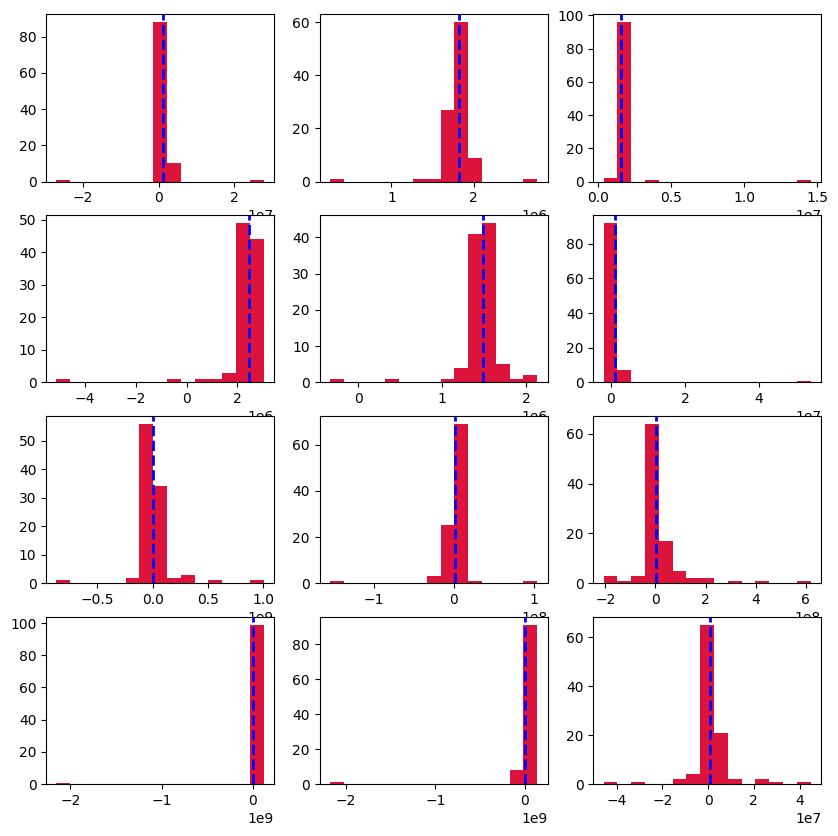

In [749]:
fig,axs = plt.subplots( 4,3,figsize=(10,10),facecolor="white" )
for k in range(df_preproduction.shape[0]):
    row = k//3
    colm = k%3
    id = df_preproduction.iloc[k]["Well_ID"]
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ id ]["realizations"],color="crimson",bins=15 )
    axs[row,colm].axvline( realizations_per_sample[ id ]["best_pred"],ls="--",lw=2.0,color="blue" )

In [714]:
df_solution = pd.read_csv( "solution.csv" )
for id in df_solution["Well_ID"].values:
    df_solution.loc[df_solution["Well_ID"]==id,"Prediction_BBL"] = realizations_per_sample[id]["best_pred"]
    df_solution.loc[df_solution["Well_ID"]==id, df_solution.columns[2:]] = realizations_per_sample[id]["realizations"]
df_solution

/tmp/ipykernel_56024/1579202467.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1197888.7071159668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solution.loc[df_solution["Well_ID"]==id,"Prediction_BBL"] = realizations_per_sample[id]["best_pred"]
/tmp/ipykernel_56024/1579202467.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1194141.3741267417' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solution.loc[df_solution["Well_ID"]==id, df_solution.columns[2:]] = realizations_per_sample[id]["realizations"]
/tmp/ipykernel_56024/1579202467.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1513589.0105465779' has dtype incompatible with int64, please 

,Well_ID,Prediction_BBL,R1,R2,R3,R4,R5,R6,R7,R8,...,R91,R92,R93,R94,R95,R96,R97,R98,R99,R100
0,72,1.197889e+06,1.194141e+06,1.513589e+06,2.019222e+06,1.418838e+06,9.233408e+05,-9.223167e+06,9.549834e+05,1.371304e+06,...,1.153901e+06,-5.686985e+06,5.360337e+05,1.190327e+06,1.775101e+06,1.165655e+06,1.015011e+06,8.957322e+05,3.931180e+06,8.518485e+05
1,73,1.808666e+06,1.671809e+06,1.866773e+06,1.824681e+06,1.836126e+06,1.898564e+06,1.738466e+06,1.778516e+06,1.798383e+06,...,1.945320e+06,1.882408e+06,1.742927e+06,1.875421e+06,1.855548e+06,1.774322e+06,1.787685e+06,1.820213e+06,1.850855e+06,1.879528e+06
2,74,1.603265e+06,1.260584e+06,1.572639e+06,1.441286e+06,1.575400e+06,1.564416e+06,1.619491e+06,1.626407e+06,1.710462e+06,...,1.592678e+06,1.586083e+06,1.341560e+06,1.560265e+06,1.550555e+06,1.560093e+06,1.522821e+06,1.579321e+06,1.598149e+06,1.612981e+06
3,75,2.470782e+06,2.492736e+06,1.239805e+06,2.349943e+06,2.680247e+06,2.350346e+06,2.363406e+06,1.900533e+06,2.659052e+06,...,2.394184e+06,2.508615e+06,2.601444e+06,2.640959e+06,2.320949e+06,2.565257e+06,2.503273e+06,1.892179e+06,2.726875e+06,2.664380e+06
4,76,1.469354e+06,1.462265e+06,3.006105e+06,1.474132e+06,1.485832e+06,1.469925e+06,1.432111e+06,1.465940e+06,8.971991e+05,...,1.477732e+06,1.448200e+06,1.398815e+06,1.514769e+06,1.468574e+06,1.596257e+06,1.365528e+06,1.491278e+06,1.421814e+06,1.299546e+06
5,77,1.251737e+06,1.301437e+06,1.277569e+06,8.201080e+05,1.320226e+06,4.978535e+06,1.606657e+06,1.325512e+06,1.302532e+06,...,1.244511e+06,1.201185e+06,1.052592e+07,1.294345e+06,1.276680e+06,4.878729e+05,4.899679e+06,1.314159e+06,6.516089e+06,1.031943e+06
6,78,1.670626e+06,7.415669e+06,-2.279760e+06,-1.342156e+07,4.843275e+07,8.592143e+07,2.358843e+05,2.940362e+06,3.354412e+06,...,4.054161e+07,-2.650387e+08,7.450116e+07,2.058090e+06,-1.469153e+06,-1.660276e+07,-6.739622e+06,-1.790208e+06,-6.004011e+06,-1.408973e+06
7,79,8.502449e+05,2.126096e+06,-7.689814e+05,7.616325e+05,6.796718e+05,7.969751e+05,3.098775e+05,3.955561e+06,7.421923e+05,...,3.338005e+06,8.506478e+05,4.206880e+06,2.690512e+06,7.154898e+05,3.147770e+06,3.124523e+06,-4.800488e+06,9.228228e+05,3.068432e+06
8,80,5.010997e+05,5.527067e+06,-3.265539e+06,-1.035206e+07,5.329142e+07,-6.763018e+07,1.171655e+08,-5.994844e+07,-4.898145e+07,...,9.172597e+06,9.742878e+06,6.772235e+05,2.355112e+06,-1.174631e+08,-4.965423e+06,-6.439751e+07,-3.423354e+07,1.266094e+07,4.897807e+07
9,81,7.203380e+05,4.572326e+06,7.214444e+05,1.348161e+06,3.606379e+06,3.712690e+06,7.225701e+05,-8.321733e+07,2.933120e+05,...,7.178772e+05,-7.162289e+06,7.427987e+05,-5.750646e+06,-1.662693e+06,-3.470838e+06,7.181034e+05,-5.390727e+06,7.193963e+05,-2.210417e+06


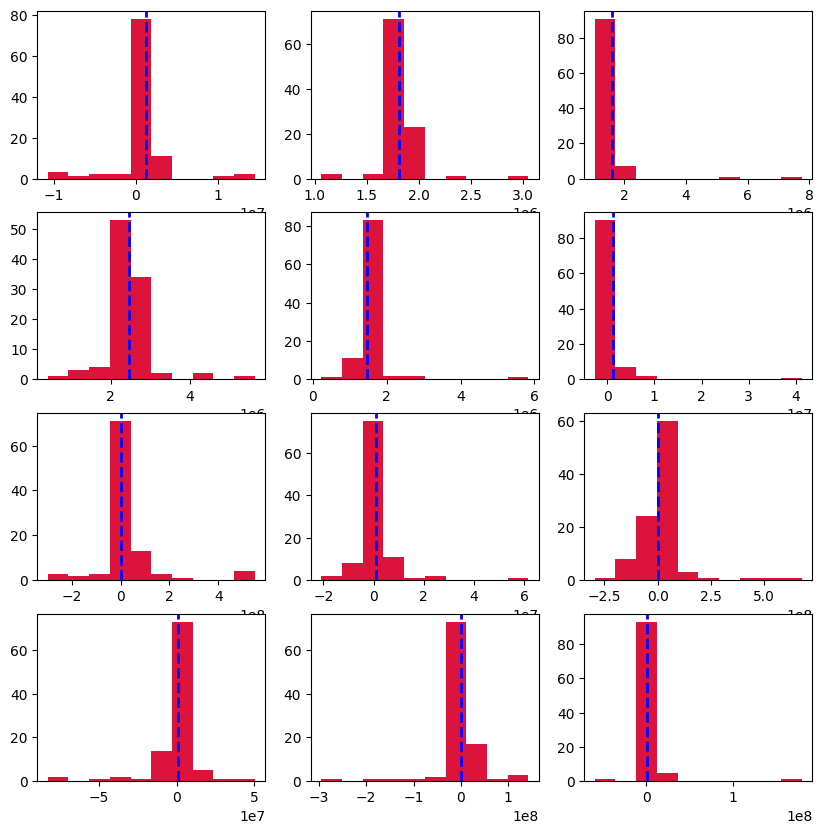

In [717]:
fig,axs = plt.subplots( 4,3,figsize=(10,10),facecolor="white" )
for k in range(df_preproduction.shape[0]):
    row = k//3
    colm = k%3
    id = df_preproduction.iloc[k]["Well_ID"]
    counts, bin_edges, patches = axs[row,colm].hist(  df_solution.loc[ df_solution["Well_ID"]==id,"R1":"R100" ].values.ravel(),color="crimson",bins=10 )
    axs[row,colm].axvline( df_solution.loc[ df_solution["Well_ID"]==id,"Prediction_BBL"].values,ls="--",lw=2.0,color="blue" )

### PC

In [240]:
df_pca = df_out[["gamma_var","gamma_mean","mean_por","mean_perm","Y","X","acoustic_imp","kophi_mean_of_sqrts","Well_ID","cumulative_3y"]]
print(f"rows: {df_pca.shape}")
df_pca = df_pca.dropna(  )
print(f"rows: {df_pca.shape}")

rows: (71, 10)
rows: (71, 10)


In [249]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X = df_pca.iloc[:,:-1]
X_new = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
df_pca["pc1"] = X_new[:,0]
df_pca["pc2"] = X_new[:,1]

[9.20728953e-01 7.92710423e-02 3.74220673e-09 5.57382937e-10
 2.34196605e-10]


<Axes: xlabel='pc1', ylabel='pc2'>

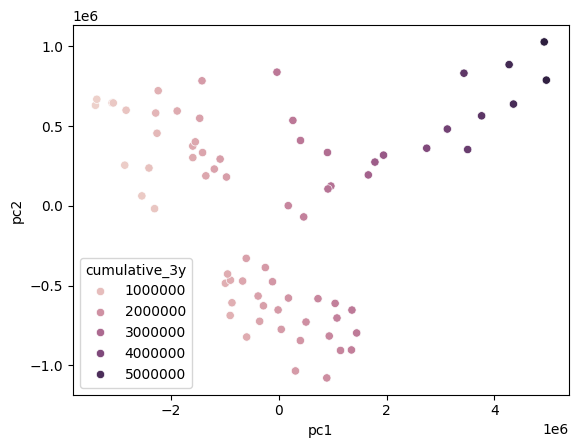

In [250]:
sb.scatterplot( data=df_pca,x="pc1",y="pc2",hue="cumulative_3y")#acoustic_imp" )

### Model Construction

In [259]:
# X = df_out[["gamma_var","mean_perm","mean_por"]].values
X = df_out[["X","Y"]].values
y = df_out["cumulative_3y"].values
kf = KFold(n_splits=5)#,shuffle=True)
r2scores = [  ]
for i, (train_index, test_index) in enumerate(kf.split(X)):
    pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', DecisionTreeRegressor(  ))] )
    X_train, X_test, y_train, y_test = X[train_index,:],X[test_index,:],y[train_index],y[test_index]
    pipe.fit(X_train, y_train)
    ypred = pipe.predict( X_test )
    r2scores.append( r2_score( y[test_index],ypred ) )


In [260]:
r2scores

[-2.3587450163011976,
 -0.5905180131060885,
 -19.28684989254235,
 -0.6675590240380394,
 -1.2465146420885826]